In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'

plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5

dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = ['-', '--', '-.', ':']

pd.set_option('future.no_silent_downcasting', True)

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

## Get data

In [3]:
# directories
data_dir = os.path.abspath('../data')
char_dir = os.path.join(data_dir, 'chart')
summ_dir = os.path.join(data_dir, 'summary')
earn_dir = os.path.join(data_dir, 'earnings')

In [4]:
# get symbols
parse_symbol = lambda file : '-'.join(file.split('.')[0].split('-')[1:])
char_symbs = {parse_symbol(x) for x in os.listdir(char_dir)}
summ_symbs = {parse_symbol(x) for x in os.listdir(summ_dir)}
earn_symbs = {parse_symbol(x) for x in os.listdir(earn_dir)}

symbols = sorted(char_symbs & summ_symbs & earn_symbs)
len(symbols)

477

In [ ]:
def load_price(symbol):
    '''
    Load and clean chart data (adjusted prices, volume by share, market cap).
    '''

    symbol = symbol.lower()
    src = os.path.join(char_dir, f'chart-{symbol}.json')
    with open(src, 'r') as f:
        chart = json.load(f)

    src = os.path.join(summ_dir, f'summary-{symbol}.json')
    with open(src, 'r') as f:
        summary = json.load(f)

    timestamp = chart['timestamp']
    quote = chart['indicators']['quote'][0]
    adjclose = chart['indicators']['adjclose'][0]
    data = quote | adjclose

    df = pd.DataFrame(data, index=timestamp)
    df.index = df.index.astype('datetime64[s]').date
    df = df.reset_index(names='date')

    # adjusted price adjusts for dividends also
    df['adj'] = df['adjclose'] / df['close']

    cols = ['open', 'close', 'low', 'high', 'volume']
    df[cols] = df[cols].mul(df['adj'], axis=0)

    # mean price
    cols = ['open', 'close', 'low', 'high']
    df['mean'] = df[cols].mean(axis=1)

    # volume by outstanding shares
    shares_outstanding = summary['defaultKeyStatistics']['sharesOutstanding']['raw']
    df['volshare'] = df['volume'] / shares_outstanding

    # intraday mean price market cap
    df['mkcap'] = df['mean'] * shares_outstanding
    df = df.dropna(axis=0, how='all')

    return df

In [6]:
def load_earnings(symbol):
    '''
    Clean and load earnings data
    '''
    src = os.path.join(earn_dir, f'earnings-{symbol}.json')
    with open(src, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    
    if len(df)==0: # empty data frame
        return df
    
    ds = df['Earnings Date'].str.split(' at ').str[0]
    df['date'] = pd.to_datetime(ds).dt.date

    # clean columns
    cols = df.columns
    cols = cols.str.lower()
    remove = ['(%)', 'eps']
    for x in remove:
        cols = cols.str.replace(x, '')
    cols = cols.str.strip()
    cols = cols.str.replace(' ', '_')
    df.columns = cols

    # clean data
    cols = ['estimate', 'reported', 'surprise']
    df[cols] = df[cols].replace('-', 'NaN').astype(float)
    df['surprise'] = df['surprise'] * 0.01
    
    return df

In [7]:
prices = {}
earnings = {}
N = len(symbols)

print('Progress (/10): |', end='')

i = 0
for n, symbol in enumerate(symbols):

    prices[symbol] = load_price(symbol)
    earnings[symbol] = load_earnings(symbol)

    # progress bar
    if n % int(N/10) == 0:
        print(i, end=' ')
        i+=1
        
print('|')

Progress (/10): |0 1 2 3 4 5 6 7 8 9 10 |


# Prices

In [ ]:
# combine all prices into dataframes

# price data
dfp = pd.concat(prices)

dfp.index.names = ['ticker', 'index']
dfp = dfp.reset_index()

# earnings data
dfe = pd.concat(earnings)
dfe.index.names = ['ticker', 'index']
dfe = dfe.reset_index()

In [ ]:
dfe['ticker'] = dfe['ticker'].str.lower()


dfe['earn'] = True

cols = ['ticker', 'date', 'earn', 'estimate', 'reported', 'surprise']
merge = pd.merge(dfp, dfe[cols], on=['ticker', 'date'], how='left')
merge['earn'] = merge['earn'].fillna(False)
merge['date'] = pd.to_datetime(merge['date'])

In [172]:
tickers = merge['ticker'].unique().tolist()

In [ ]:
ticker = 'RDDT'

# plot relative price and demarcate earnings dates for this year# plo
cond1 = merge['date'].dt.year >= 2025
cond2 = merge['ticker'] == ticker.lower()
cond = cond1 & cond2

sdf = merge[cond]

# resample to weekly mean for plotting
# sdf = sdf.set_index('date').resample('W').last()


fig, ax = plt.subplots(figsize=(12,6))

# plot adjusted close price
x, y = sdf['date'], sdf['adjclose']
y = (y / y.iloc[0]) - 1 # normalize to begnning price
ax.plot(x, y, label='Adj Close Price', color=dcolors[0])

# demarcate earnings dates
earn_dates = sdf[sdf['earn']==True]['date']

for ed in earn_dates:
    ax.axvline(ed, color='red', linestyle='--', alpha=0.5)

# plot secondary y-axis
ax2 = ax.twinx()
color = 'gray'

# volume to shares outstanding 
x, y = sdf['date'], sdf['volshare']
y = y.cumsum()
ax2.plot(x, y, color=color, alpha=0.5)  
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Cumulative Volume by Share', color=color)
ax2.grid(False)


# # log price
# x, y = sdf['date'], np.log(sdf['adjclose'])
# y = y - y.iloc[0] # (y / y.iloc[0]) - 1 # normalize to beginning log price
# ax.plot(x, y, color=color, alpha=0.5)


# labels and title
ax.set_ylabel('Adjusted Close Price (USD)')
ax.set_xlabel('Date')
ax.set_title(f'Adjusted Close Price for {ticker.upper()} with Earnings Dates')

xmin, xmax = x.min(), x.max()
ax.set_xlim(xmin, xmax)


plt.show()

IndexError: single positional indexer is out-of-bounds

In [87]:
close = dfp.pivot(columns='ticker', index='date', values='adjclose')
close.index = pd.DatetimeIndex(close.index)

# compute correlation for years >= 2025
cond = close.index.year >= 2025
corr = close[cond].corr()
ds = corr['googl'].sort_values(ascending=False)
ds

ticker
googl    1.000000
goog     0.999956
wbd      0.955799
mu       0.952511
lrcx     0.948244
           ...   
fds     -0.890313
mmc     -0.901563
invh    -0.906477
vrsk    -0.927571
bro     -0.931273
Name: googl, Length: 477, dtype: float64

In [88]:
close['googl']

date
1962-01-02           NaN
1962-01-03           NaN
1962-01-04           NaN
1962-01-05           NaN
1962-01-08           NaN
                 ...    
2025-12-19    307.160004
2025-12-22    309.779999
2025-12-23    314.350006
2025-12-24    314.089996
2025-12-26    313.510010
Name: googl, Length: 16105, dtype: float64

In [81]:
cond = ds.abs() >= 0.85
ds[cond]

ticker
aapl     1.000000
ter      0.938751
goog     0.905190
googl    0.903854
pld      0.894354
spg      0.892311
wbd      0.862024
vrsk    -0.881210
Name: aapl, dtype: float64

In [54]:
corr['googl']

ticker
a       0.730164
aapl    0.903854
abbv    0.552338
abnb   -0.002894
abt     0.061673
          ...   
xyl     0.741845
xyz     0.659236
yum    -0.129327
zbh     0.088764
zts    -0.831036
Name: googl, Length: 477, dtype: float64

# Spreads

In [9]:
# get spread : mean price ratio
dfp['spread'] = dfp['high'] - dfp['low']
dfp['spread_ratio'] = (dfp['spread'] / dfp['mean'])

# unwgt. mean spreads by company has tight distribution
pvt = dfp.pivot_table(index='ticker', values=['spread_ratio', 'volshare'], aggfunc=['mean', 'max', 'min', 'std', 'count'])

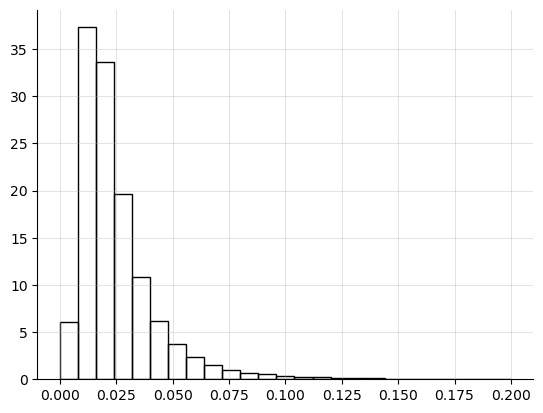

count    4.111136e+06
mean     2.539904e-02
std      2.144177e-02
min      0.000000e+00
25%      1.353648e-02
50%      1.998859e-02
75%      3.043241e-02
max      1.333333e+00
Name: spread_ratio, dtype: float64

In [10]:
# daily spreads are quite dispersed
COL = 'spread_ratio'
ds = dfp[COL]
cond = (0 < ds) & (ds < .2)
ds[cond].hist(bins=25, fill=None, density=True)
plt.show()

ds.describe()

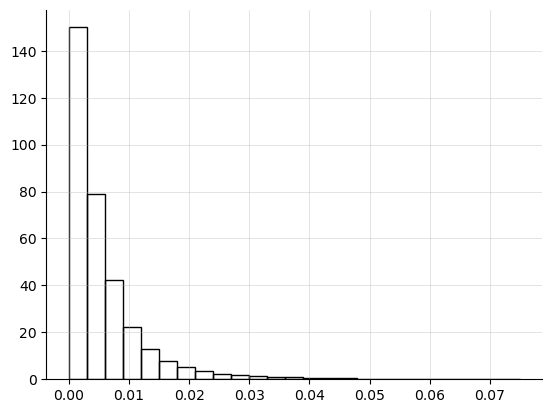

count    4.111136e+06
mean     6.021921e-03
std      1.220805e-02
min      0.000000e+00
25%      9.630506e-04
50%      3.518878e-03
75%      7.261920e-03
max      1.056957e+01
Name: volshare, dtype: float64

In [11]:
# daily volshare are quite dispersed
COL = 'volshare'
ds = dfp[COL]
cond = (0 < ds) & (ds < .075)
ds[cond].hist(bins=25, fill=None, density=True)
plt.show()

ds.describe()

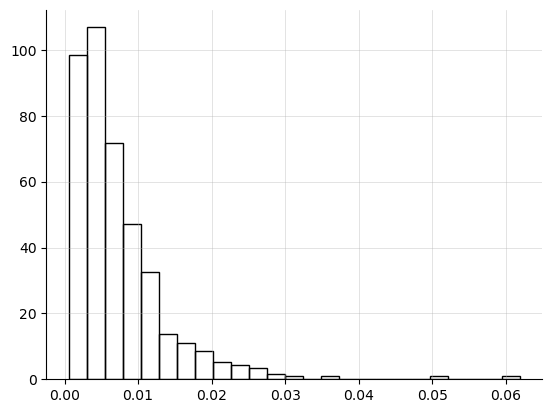

count    477.000000
mean       0.007270
std        0.006427
min        0.000590
25%        0.003114
50%        0.005435
75%        0.009077
max        0.061891
Name: volshare, dtype: float64

In [12]:
COL = 'volshare'
ds = pvt['mean'][COL]
ds.hist(bins=25, fill=None, density=True)
plt.show()
ds.describe()

In [13]:
# top companies by mean spread ratio
TOP = 10
COL = 'spread_ratio'

sdf = pvt['mean'].sort_values(by=COL, ascending=False).head(TOP)
sdf['days'] = pvt['count'][COL]
sdf['years'] = (sdf['days'] / (52 * 5)).round(1) # assuming 5 trading days per week

top_spreads = sdf.index.tolist()
print('Companies with highest mean daily spread ratio')
sdf

Companies with highest mean daily spread ratio


,spread_ratio,volshare,days,years
ticker,,,,
mnst,0.073490,0.009034,10030,38.6
coin,0.067793,0.051249,1123,4.3
mrna,0.058654,0.021455,1713,6.6
app,0.056146,0.012215,1122,4.3
hood,0.055706,0.024982,1049,4.0
pltr,0.054248,0.026381,1257,4.8
on,0.047724,0.014427,6393,24.6
ttd,0.047400,0.020952,2269,8.7
dash,0.047250,0.010523,1207,4.6


MNST


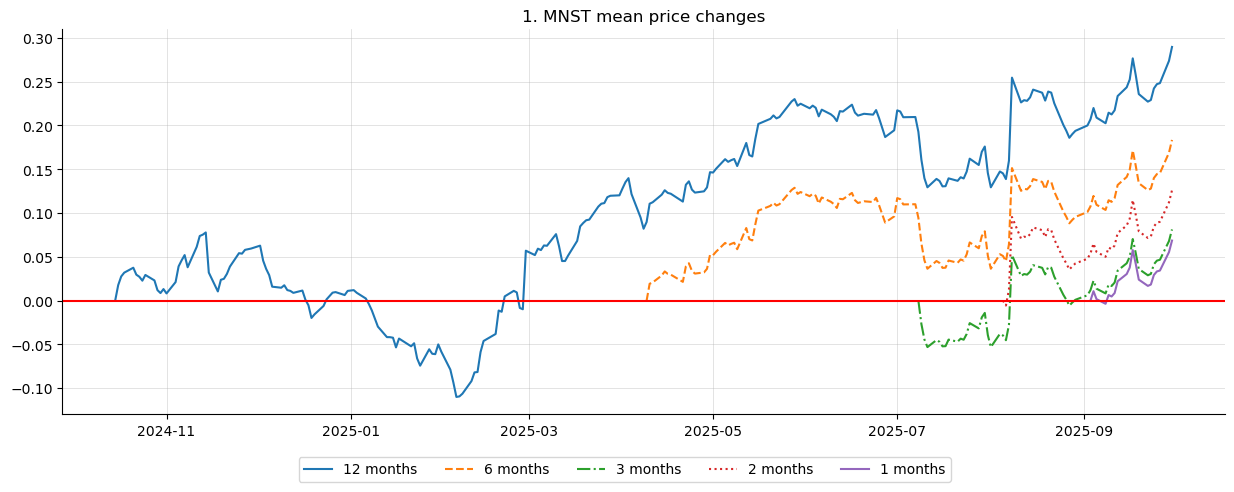

COIN


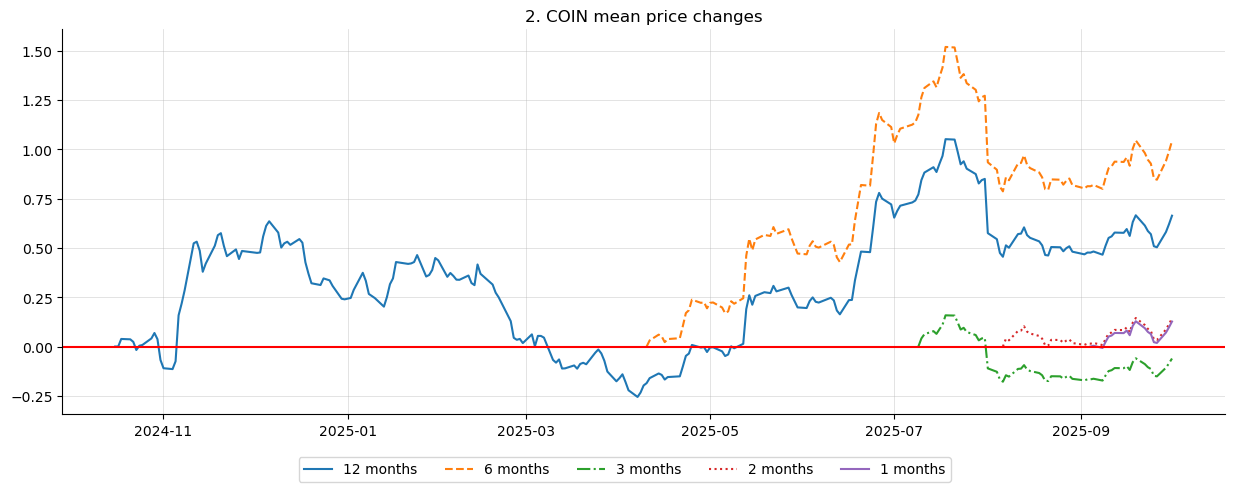

MRNA


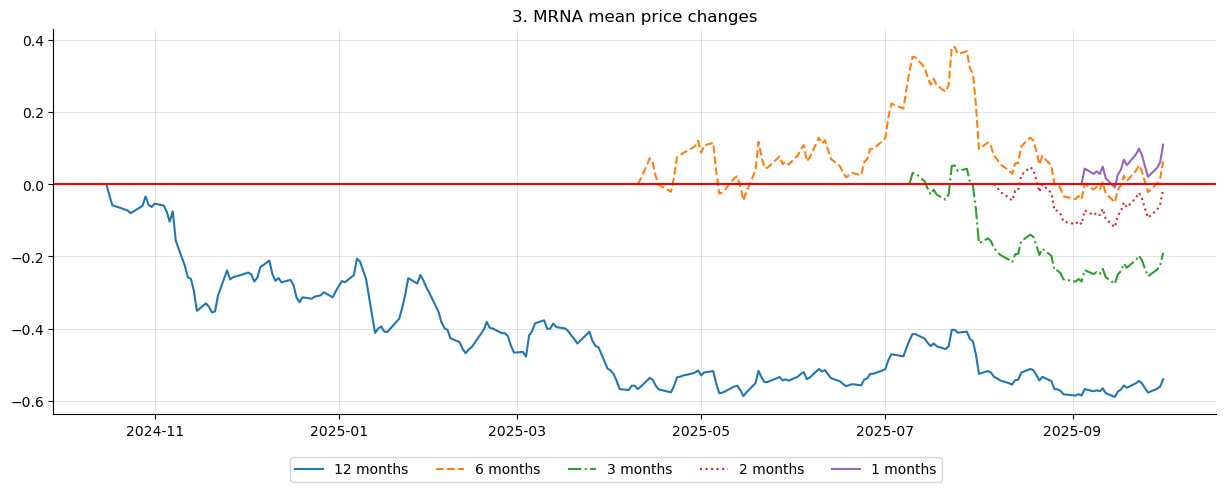

APP


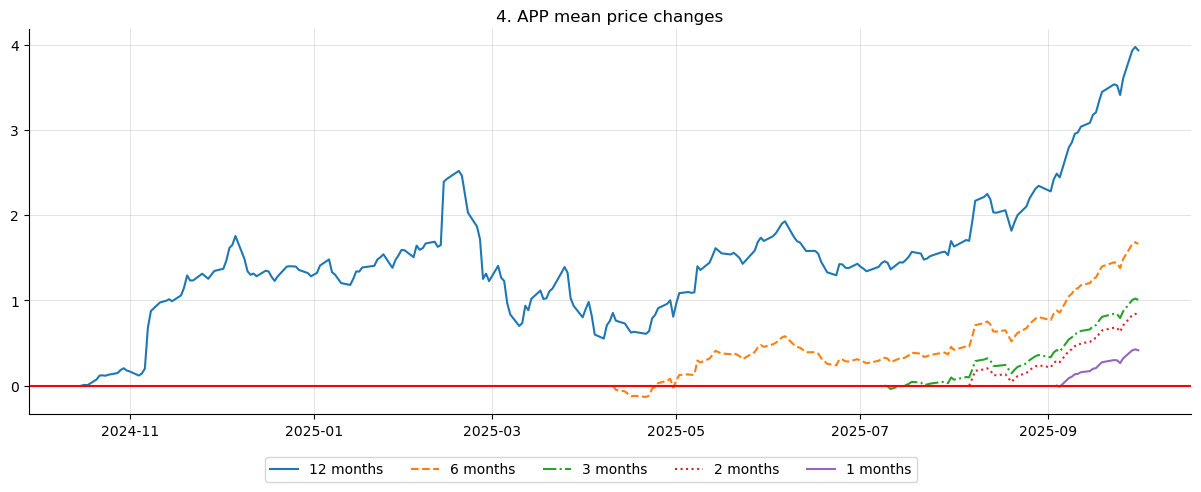

HOOD


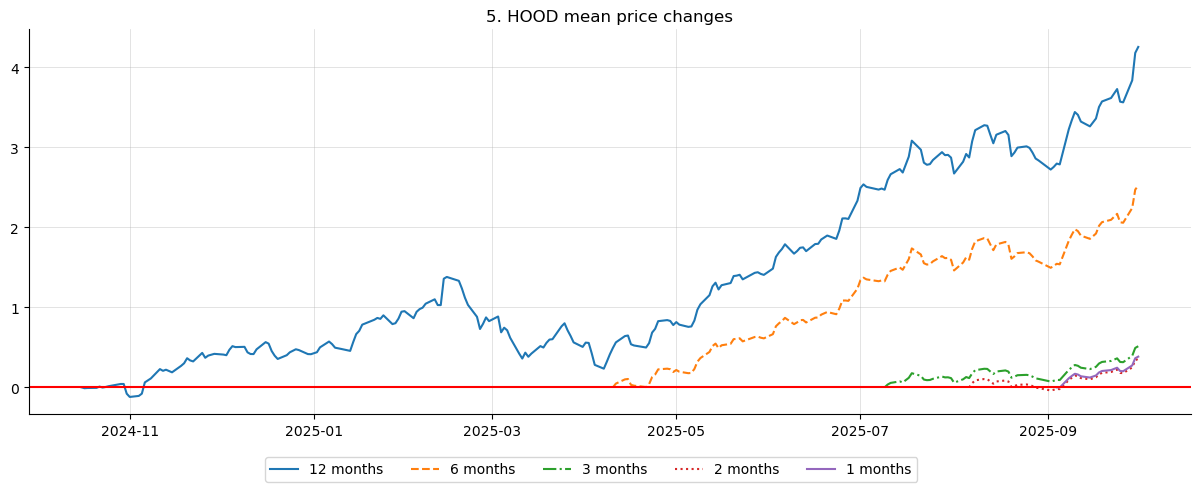

PLTR


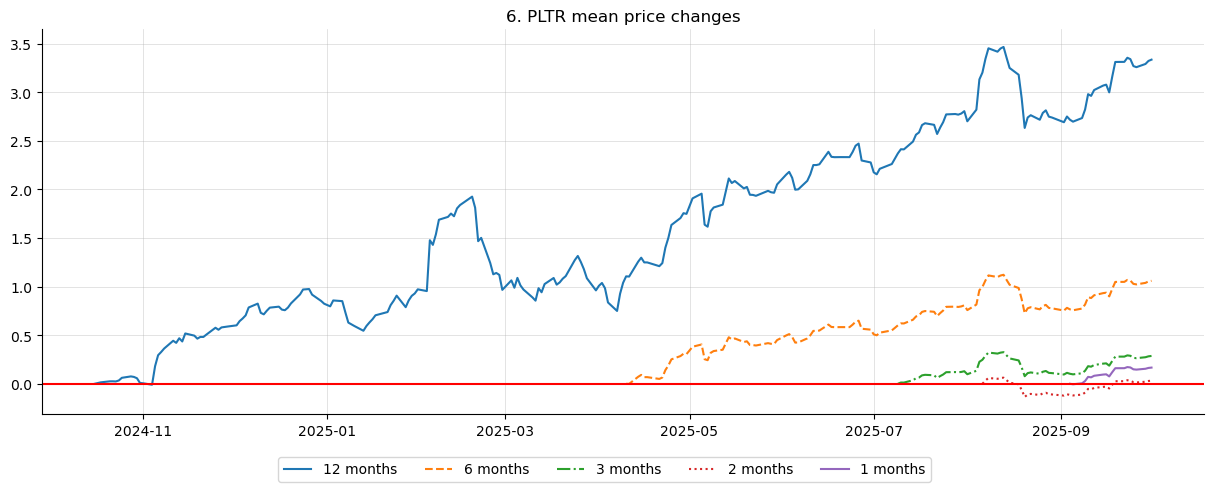

ON


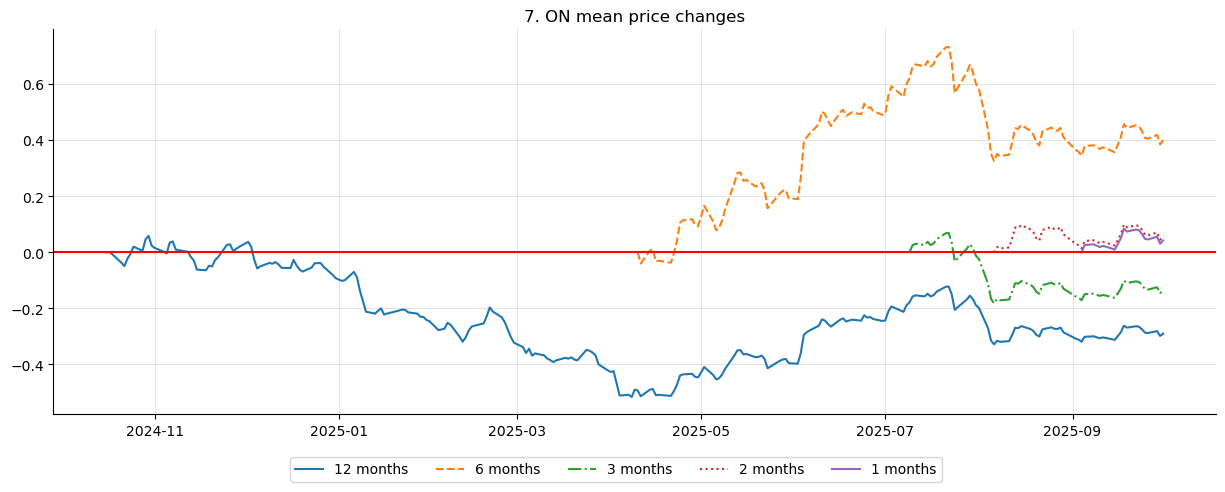

TTD


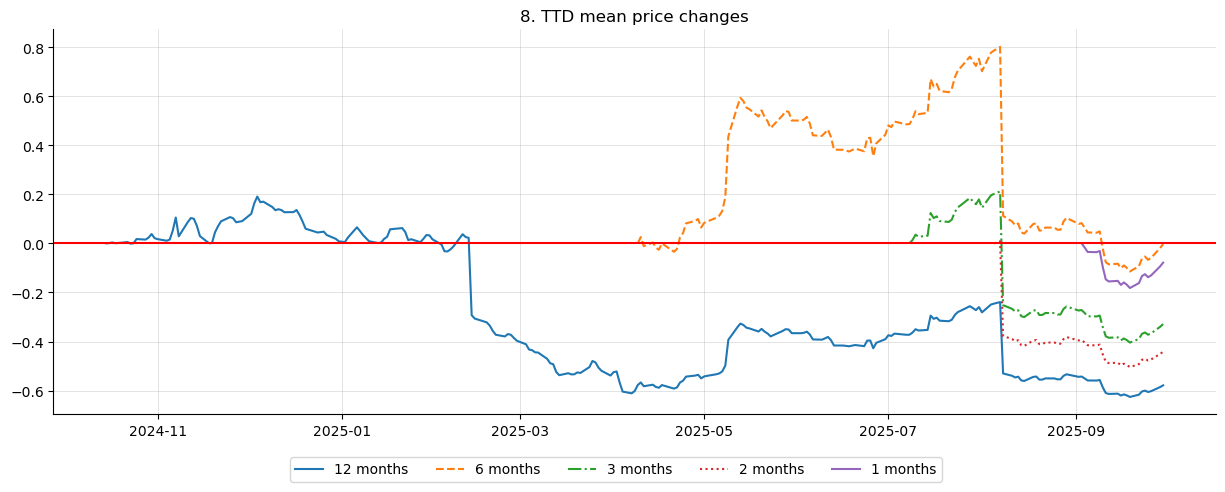

DASH


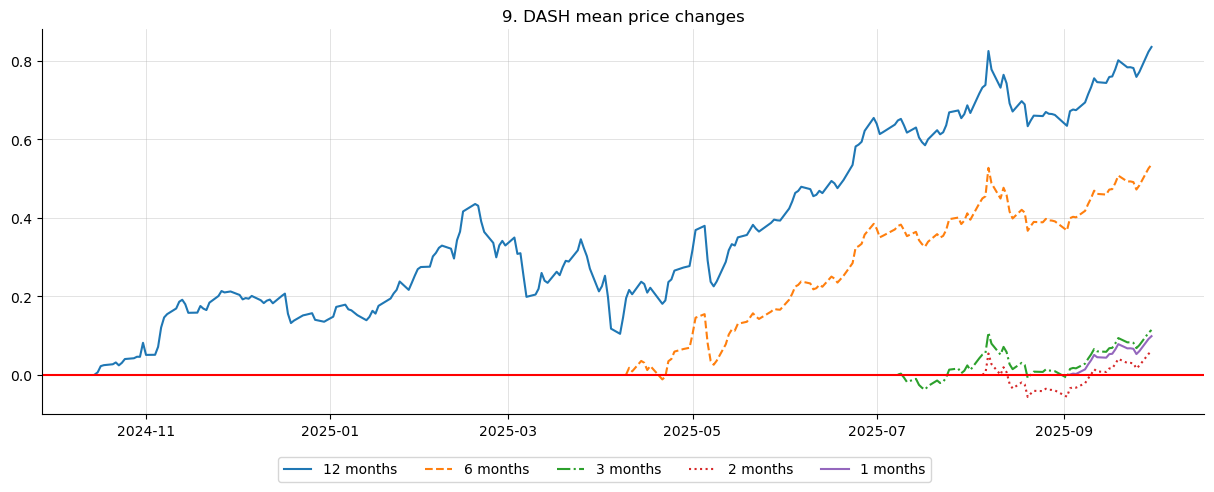

WDC


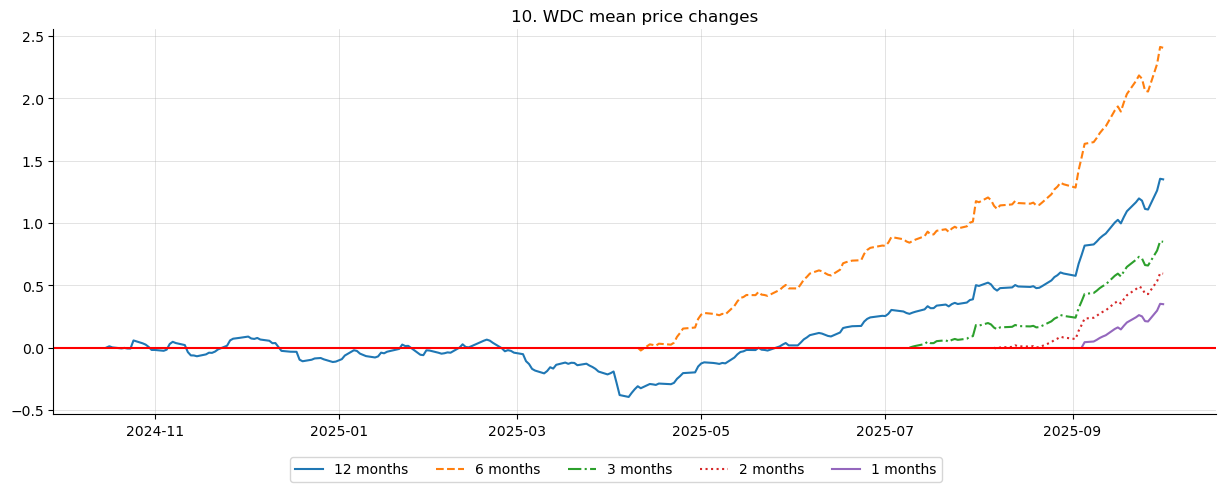

In [14]:
# plot prices
PRICE_COL = 'mean'
MONTHS = [1, 2, 3, 6, 12]
MONTHS = sorted(MONTHS, reverse=True)

n = 0
for ticker in top_spreads:

    print(ticker.upper())
     
    # stock price
    cond = dfp['ticker'] == ticker
    sdf = dfp[cond]
    sdf = sdf.sort_values('date', ascending=True)

    ncols = len(MONTHS)
    fig, ax = plt.subplots(figsize=(ncols*3, 5))
    
    for i, months in enumerate(MONTHS):
        
        # price change
        days = (months*20) # assuming 20 trading days per month
        ds = sdf[PRICE_COL].tail(days)

        x = sdf['date'].tail(days)
        y = (ds/ds.iloc[0]) - 1 # gross price change
        
        ax.plot(x, y, color=dcolors[i], ls=ls[i%len(ls)], label=f'{months} months')
        
    # ax.tick_params(axis='x', rotation=-15)
    ax.axhline(0, c='r')
    

    n+=1
    ax.set_title(f'{n}. {ticker.upper()} {PRICE_COL} price changes')
    fig.legend(bbox_to_anchor=(0.5, 0), ncol=len(MONTHS), loc='center')

    plt.show()

mnst
coin


/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inplace=True)
/tmp/ipykernel_2006/338265401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1
/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inpla

mrna
app


/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inplace=True)
/tmp/ipykernel_2006/338265401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1
/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inpla

hood
pltr


/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inplace=True)
/tmp/ipykernel_2006/338265401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1
/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inpla

on
ttd


/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inplace=True)
/tmp/ipykernel_2006/338265401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1
/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inpla

dash
wdc


/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inplace=True)
/tmp/ipykernel_2006/338265401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1
/tmp/ipykernel_2006/338265401.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.sort_values(by='date', inpla

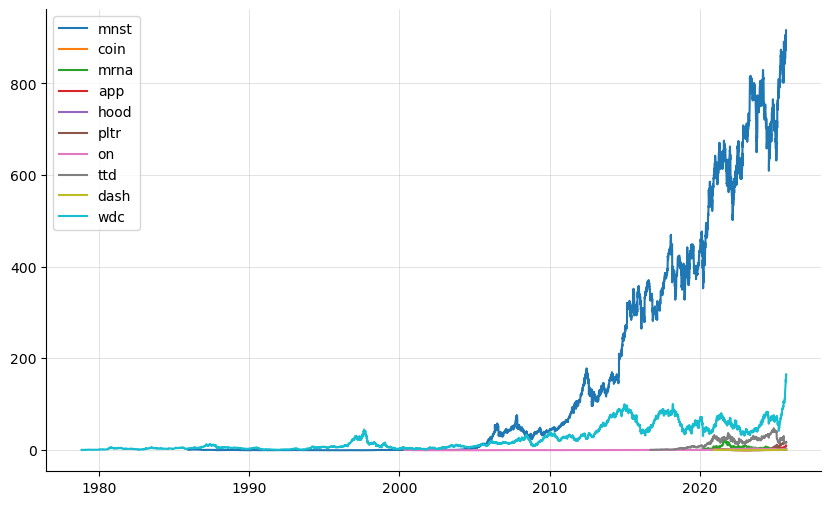

In [15]:
PRICE_COL = 'mean'

fig, ax = plt.subplots(figsize=(10, 6))

for ticker in top_spreads:

    print(ticker)
    cond = (dfp['ticker'] == ticker)
    sdf = dfp[cond]
    sdf.sort_values(by='date', inplace=True)

    sdf['growth'] = (sdf[PRICE_COL] / sdf[PRICE_COL].iloc[0])-1

    x, y = sdf['date'], sdf['growth']
    ax.plot(x, y, label=ticker)

ax.legend()
plt.show()

In [16]:
# TODO: look at high spread ratio events
THRESHOLD = 0.1

cond = dfp['spread_ratio'] > THRESHOLD
sdf = dfp[cond]


# Returns

In [17]:
# TODO
# - look at top n daily return stocks
# - look at weekly returns

In [18]:
# returns dataframe
dfr = pd.concat(returns)
dfr.index.names = ['ticker', 'date']
dfr = dfr.reset_index()

dfr['date'] = dfr['date'].astype('datetime64[s]')

# calculate rank
PRICE_COLS = ['low', 'high', 'open', 'close', 'mean']

for col in PRICE_COLS:
    print(col)
    dfr = dfr.sort_values(['date', col], ascending=False)
    dfr[f'rank_{col}'] = dfr.groupby('date').cumcount()

NameError: name 'returns' is not defined

In [ ]:
# distriubtion of top 5 
TOP = 5
COL = 'low'

cond = dfr[f'rank_{COL}'] < TOP
top = dfr[cond]

top = top.set_index(['date', 'ticker'])
top = top.sort_values(['date', COL], ascending=False)

top.head(50)

pv = dfr.pivot(index='date', columns='ticker', values=PRICE_COLS)
data = {}
for col in PRICE_COLS:
    data.update({
        ('ticker', col) : pv[col].idxmax(axis=1),
        ('max', col) : pv[col].max(axis=1)
        })
    
# stocks with highest one-day return
rmax = pd.DataFrame(data)
display(rmax.tail(20))

ticks = 0.01
pct = rmax['max']
pct = (pct / ticks).round(0) * ticks
counts = pct.apply(pd.value_counts)
counts.index.name = 'Daily return %'
freq = counts / counts.sum()

fig, ax = plt.subplots()


ds = freq[COL]
x, y = ds.index, ds.values
ax.plot(x, y, label=col, marker='o', fillstyle='none', alpha=0.6)
ax.set_title(f'Density of change in daily {COL} price for daily top {TOP} movers')

ax.set_xlim(-.2, .5)

ax.legend()
plt.show()

In [ ]:

fig, ax = plt.subplots()

weeks = 52
ds = rmax.iloc[-(weeks*5):]

col = 'low'
x, y = ds.index, ds[('max', col)]
ax.scatter(x, y, label=col, alpha=0.5)

# ax.axhline(0, ls='--', c='gray')
ax.legend()

plt.show()

## Leads and Lags

In [ ]:
col = 'low'
nshifts = 10

r = dfr[['date', 'ticker', col]]
r = r.rename(columns={col : 0})

for shift in range(-nshifts, nshifts+1):
    r[-shift] = r.groupby('ticker')[0].shift(shift)

merge = rmax['ticker'][col].reset_index()
merge.columns = ['date', 'ticker']

merge = pd.merge(merge, r, on=['date', 'ticker'], how='left')
merge = merge.set_index(['date', 'ticker'])
merge = merge[sorted(merge.columns)]
merge.columns.name = 'leads'
merge.columns = merge.columns.astype(int)

In [ ]:
# TODO
# Stratify by day 0 return level

# number of previous years
years = 3

# minimum single-day return thresholds
thresholds = np.linspace(0, 0.3, 7)


days = (years*52*5)
sdf = merge.iloc[-days:]

for threshold in thresholds:

    # filter by threshold
    cond = (sdf[0] > threshold)
    desc = sdf[cond].describe().T

    fig, ax = plt.subplots()

    ax.set_title(f'Single-day change {col} price above {threshold:.0%}'.title())

    n, N = cond.sum(), len(sdf)
    ax.set_xlabel(f'{n} of {N:,} trading days ({n/N:.2%})')

    x, y = desc.index, desc['mean']
    ci = 1.96*desc['std']

    c = 'dimgray' # dcolors[0]

    ax.plot(x, y, marker='o', fillstyle='none', c=c, label='mean')

    kwargs = dict(facecolors='None', edgecolors=c)
    ax.scatter(x, desc['max'], marker='v', label='max', **kwargs)    
    ax.scatter(x, desc['min'], marker='^', label='min', **kwargs)

    w = 0.1
    left, right = x-w, x+w

    top, bottom = y+ci, y-ci
    top = [min(x) for x in zip(top, desc['max'])]
    bottom = [max(x) for x in zip(bottom, desc['min'])]

    coords = [
        ((x, x), (top, bottom)),
        ((left, right), (top, top)),
        ((left, right), (bottom, bottom)),
    ]

    for h, v in coords:
        ax.plot(h, v, c=c, lw=0.75)

    ax.set_xticks(x[::2])
    ax.axhline(0, ls='--', c='red', lw=0.5)
    ax.yaxis.minorticks_on()

    plt.show()